# Implementing quantum money from knots

In this notebook we will make an attempt to implement quantum money from knots, see https://arxiv.org/pdf/1004.5127.pdf. To start, we give an example of how to set up a uniform superposition in qiskit on $n=4$ qubits. 

In [198]:
import numpy as np
import GridPyM as g
from scipy.sparse import csc_matrix
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import ZGate, MCMT
from tqdm.notebook import tqdm
import random
import qiskit.tools.jupyter

## Starting small: generate uniform superposition on 4 qubits


In [199]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute

# Print the statevector in bra-ket notation with a maximum of 3 decimal places
def print_state(statevector, n):
    print("Amplitudes of the statevector: ")
    for i, amplitude in enumerate(np.asarray(statevector)):
        binary = f"{i:04b}"
        ket = "|" + binary.zfill(n) + ">"
        print(f"{ket}: {np.round(float(amplitude), 3)} ")

def test(n):
    # Create a quantum circuit with n qubits
    qc = QuantumCircuit(n,n)

    # Apply a Hadamard gate to each qubit to create a uniform superposition
    qc.h(range(n))

    # Execute the circuit on the local simulator
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)

    # Get the resulting statevector
    statevector = job.result().get_statevector(qc)
              
        
    # Filter out unwanted states, for example all even basis vectors
    for i in range(len(statevector)):
        if i % 2 == 0:  # replace with your condition
            np.asarray(statevector)[i] = 0
            
    print_state(statevector, n)

test(4)      

Amplitudes of the statevector: 
|0000>: 0.0 
|0001>: 0.25 
|0010>: 0.0 
|0011>: 0.25 
|0100>: 0.0 
|0101>: 0.25 
|0110>: 0.0 
|0111>: 0.25 
|1000>: 0.0 
|1001>: 0.25 
|1010>: 0.0 
|1011>: 0.25 
|1100>: 0.0 
|1101>: 0.25 
|1110>: 0.0 
|1111>: 0.25 


Our goal will be to create a superposition over grid diagrams. So we will need to find a way correspond grid diagrams to bitstrings. 

## From permutation to binary string
A permutation of n elements can be represented as a binary string of length n! using a technique called factorial number system or factoradic. In this system, each digit of the binary string represents a factorial base $(0!, 1!, 2!, 3!, \ldots)$, and the value of the permutation is obtained by multiplying each digit by its corresponding factorial base and summing the results.

Here’s an example of how to represent the permutation $[2, 0, 1]$ as a binary string using the factorial number system:

<ul>
    <li>First, we need to find the Lehmer code of the permutation. This is done by counting the number of elements to the right of each element that are smaller than it. For the permutation $[2, 0, 1]$, the Lehmer code is $[2, 0, 0]$ because there are two elements to the right of $2$ that are smaller than it ($0$ and $1$), and no elements to the right of 0 or 1 that are smaller than them.
    <li>Next, we convert the Lehmer code to a binary string using the factorial number system. The first digit of the Lehmer code $(2)$ is multiplied by its corresponding factorial base $(2!)$ to obtain $4$. The second digit $(0)$ is multiplied by its corresponding factorial base $(1!)$ to obtain $0$. The third digit $(0)$ is multiplied by its corresponding factorial base $(0!)$ to obtain $0$. The sum of these values is $4 + 0 + 0 = 4.$
    <li>Finally, we convert this value to a binary string to obtain the final representation of the permutation as a binary string. In this case, the binary representation of $4$ is ‘$100$’, so the permutation $[2, 0, 1]$ can be represented as a binary string ‘$100$’.
        
        
        

   






## From binary string to permutation
<ul>
<li>
First, we need to convert the binary string to its corresponding value in the factorial number system. In this case, the binary string ‘$100$’ represents the value $4$ in base $10$.
<li>
Next, we need to convert this value to its corresponding Lehmer code using the factorial number system. To do this, we divide the value by the largest factorial base $(2!)$ and obtain a quotient of $2$ and a remainder of $0$. The quotient becomes the first digit of the Lehmer code. We then divide the remainder by the next largest factorial base $(1!)$ and obtain a quotient of $0$ and a remainder of $0$. The quotient becomes the second digit of the Lehmer code. We repeat this process until all digits of the Lehmer code have been obtained. In this case, the final Lehmer code is $[2, 0, 0]$.
<li>
Finally, we need to convert the Lehmer code to its corresponding permutation. To do this, we start with an ordered list of elements $[0, 1, 2]$ and use the Lehmer code to construct the permutation. The first digit of the Lehmer code $(2)$ tells us that the first element of the permutation is the third smallest element in the list $(2)$. We remove this element from the list and obtain $[0, 1]$. The second digit of the Lehmer code $(0)$ tells us that the second element of the permutation is the first smallest element in the list $(0)$. We remove this element from the list and obtain $[1]$. The third digit of the Lehmer code $(0)$ tells us that the third element of the permutation is also the first smallest element in the list $(1)$. We remove this element from the list and obtain an empty list. The final permutation is $[2, 0, 1]$.

In [3]:
from math import factorial

def binary_to_permutation(binary_string, n):
    # Convert the binary string to its corresponding value 
    value = int(binary_string, 2)
    
    # Check if the value is within the valid range
    if not 0 <= value < factorial(n):
        raise ValueError
        
    # Convert the value to its corresponding Lehmer code
    lehmer_code = []
    for i in range(n - 1, -1, -1):
        quotient, value = divmod(value, factorial(i))
        lehmer_code.append(quotient)
    
    # Convert the Lehmer code to its corresponding permutation
    elements = list(range(n))
    permutation = []
    for code in lehmer_code:
        permutation.append(elements.pop(code))
    
    return permutation

In [4]:
def permutation_to_factoradic(permutation):
    n = len(permutation)
    factoradic = [0] * n
    for i in range(n):
        factoradic[i] = permutation[i]
        for j in range(i):
            if permutation[j] < permutation[i]:
                factoradic[i] -= 1
    return factoradic

def factoradic_to_decimal(factoradic):
    n = len(factoradic)
    decimal = 0
    for i in range(n):
        decimal += factoradic[i] * factorial(n - i - 1)
    return decimal

def permutation_to_binary(permutation):
    factoradic = permutation_to_factoradic(permutation)
    decimal = factoradic_to_decimal(factoradic)
    binary = bin(decimal)[2:]
    return binary


In [5]:
# Given an integer n, representing the number of bits available,
# return the largest integer m such that all permutations of
# length m can be reached by using n bits. This is the largest m
# such that m! < 2^n - 1.
def max_permutation_length(n):
    max_value = 2 ** n - 1
    m = 0
    while factorial(m) <= max_value:
        m += 1
    return m - 1

## From two disjoint permutations to a planar grid diagram of a link

An $n\times n$ planar grid diagram is specified by two disjoint permutation of length $n$. GridPyM is a python library that allows us to work with disjoint permutation representations of links. See https://arxiv.org/pdf/2210.07399.pdf and https://github.com/agnesedaniele/GridPythonModule.

In [7]:
# An invalid grid: the permutations are not disjoint. Gives output 1
G = [[0,1,2,3,4],[0,3,4,0,1]]
g.check_grid(G)

1

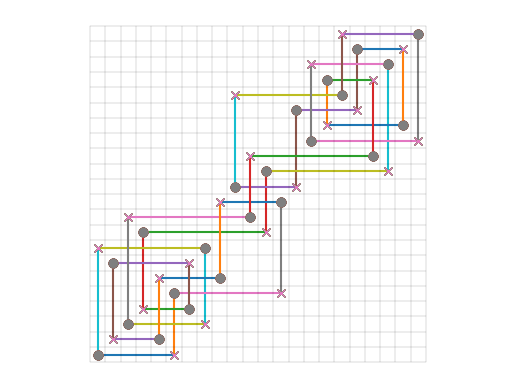

In [209]:
# Drawing example
G = [[5,1,7,3,12,4,6,0,11,2,8,13,19,10,21,15,17,9,18,14,20,16], 
     [0,4,2,6,5,8,1,7,3,10,12,9,11,18,14,20,13,16,15,19,17,21] ]
if not g.check_grid(G):
    g.draw_grid(G, markings='XO')
else:
    print("invalid")  

## Gauss code
We use Sage for calculating Alexander polynomials. Unfortunately, Sage does not support the disjoint permutation representation of links. Sage does support oriented Gauss code.

Label the crossings from $1$ to $n$ (where $n$ is the number of crossings) and start moving along the link. Trace every component of the link, by starting at a particular point on one component of the link and writing down each of the crossings that you encounter until returning to the starting point. The crossings are written with sign depending on whether we cross them as over or undercrossing. Each component is then represented as a list whose elements are the crossing numbers. A second list of $+1$ and $-1$’s keeps track of the orientation of each crossing.

In [228]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Converts a grid consisting of two disjoint permutations (as lists) to oriented gauss code supported by Sage.
# It ignores disjoint unknots without crossings contained in the diagram.
# Based on the Gauss code function of GridPyM.
def Gauss_code(grid):
    A = grid[0]
    B = grid[1]
    final_gauss_code = []
    crossing_assignment = []
    c = 1
    coord = []
    columns = [i for i in range(len(A))]
    while len(columns) > 1:
        gauss_code = []
        column = min(columns)
        flag = False
        start = column
        while flag == 0:
            valueB = B[column]
            valueA = A[column]
            if valueB < valueA:
                for i in range(valueB + 1,valueA):
                    v1 = min(A.index(i), B.index(i))
                    v2 = max(A.index(i), B.index(i))
                    if v1 < column < v2:
                        pos = [column,i]
                        if pos not in coord:
                            coord.append(pos)
                            gauss_code.append(-c)
                            c = c + 1
                            if B.index(i) > A.index(i):
                                crossing_assignment.append(-1)
                            if B.index(i) < A.index(i):
                                crossing_assignment.append(1)
                        else:
                            caux = coord.index(pos) + 1
                            gauss_code.append(-caux)
            if valueB > valueA:
                for i in range(valueB - 1, valueA, -1):
                    v1 = min(A.index(i), B.index(i))
                    v2 = max(A.index(i), B.index(i))
                    if v1 < column < v2:
                        pos = [column,i]
                        if pos not in coord:
                            coord.append(pos)
                            gauss_code.append(-c)
                            c = c + 1
                            if B.index(i) > A.index(i):
                                crossing_assignment.append(1)
                            if B.index(i) < A.index(i):
                                crossing_assignment.append(-1)
                        else:
                            caux = coord.index(pos) + 1
                            gauss_code.append(-caux)
            if B.index(valueA) > column:
                for i in range(column + 1, B.index(valueA)):
                    if min(A[i], B[i]) < valueA < max(A[i], B[i]):
                        pos = [i,valueA]
                        if pos not in coord:
                            coord.append(pos)
                            gauss_code.append(c)
                            c = c + 1
                            if B[i] > A[i]:
                                crossing_assignment.append(1)
                            if B[i] < A[i]:
                                crossing_assignment.append(-1)
                        else:
                            caux = coord.index(pos)+1
                            gauss_code.append(caux)
            if B.index(valueA) < column:
                for i in range(column - 1 ,B.index(valueA), -1):
                    if min(A[i], B[i]) < valueA < max(A[i], B[i]):
                        pos = [i, valueA]
                        if pos not in coord:
                            coord.append(pos)
                            gauss_code.append(c)
                            c = c + 1
                            if B[i] > A[i]:
                                crossing_assignment.append(-1)
                            if B[i] < A[i]:
                                crossing_assignment.append(1)
                        else:
                            caux = coord.index(pos) + 1
                            gauss_code.append(caux)
            columns.remove(column)
            column = B.index(valueA)
            if column == start:
                flag = True
        if len(gauss_code) > 0:
            final_gauss_code.append(gauss_code)
    return([final_gauss_code,crossing_assignment])

## Calculating the Alexander polynomial

One of the few already existing implementations for calculating the Alexander polynomial of oriented links is found in the Sage library. Unfortunately, the function often hangs indefinitely.

In [213]:
# Generate random 20 x 20 grid containing a 3-component link and plot it using Sage
G = g.generate_random_grid(16, 3)
#g.draw_grid(G, markings='XO')
L= Link(Gauss_code(G))
L.alexander_polynomial()

t^-1 - 2 + t

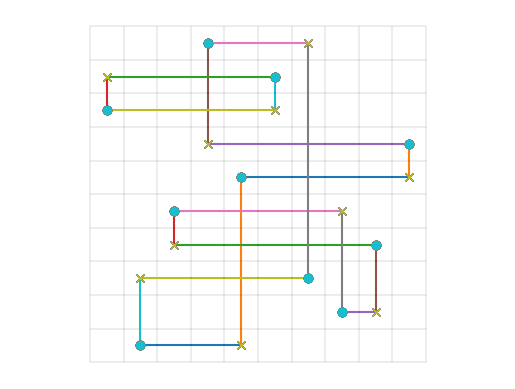

[[[1, 2, 3, -4, -5, 6, 7, 5, 4, 8, 9, -1], [-10, -9, -2, -3, -8, 10], [-6, -7]], [1, 1, -1, 1, -1, -1, 1, 1, -1, -1]]


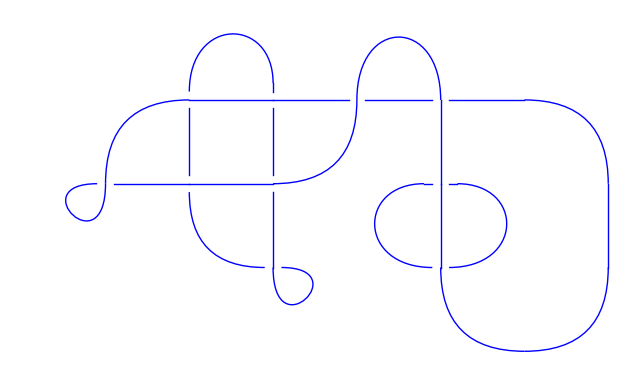

In [231]:
# Generate random 20 x 20 grid containing a 3-component link and plot it using Sage
G = g.generate_random_grid(10, 3)
g.draw_grid(G, markings='XO')
print(Gauss_code(G))
L= Link(Gauss_code(G))
L.plot()

In [197]:
# Calculate the Alexander polynomial, this often does not work for random links on n x n grids with n > 18 
L.alexander_polynomial()

t^-2 - 4*t^-1 + 6 - 4*t + t^2

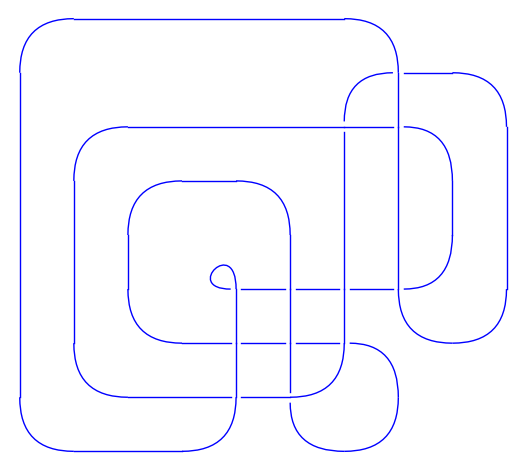

In [214]:
# Sage doesnt like the following link for example
L = Link([[[1, 2, -2, -3, -4, -5, -6, 7, -8, 9, 10, 4, -7, -11, 5, 6, 11, 8], [-9, -10, -12, -1, 3, 12]], [1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1]])
#%prun L.alexander_polynomial() # Does not work for this L 
L.plot()

## Generating a uniform superpositions of planar grid diagrams

In [235]:
# Function to check if two permutations are disjoint
def is_disjoint(coord_perm1, coord_perm2):
    for i in range(len(coord_perm1)):
        if coord_perm1[i] == coord_perm2[i]:
            return False
    return True

# Prepare a uniform superposition on n qubits and filter it to a superposition of grid diagrams
def prepare_state(n):
    # The largest m such that we can generate all permutations of length m with floor(n/2) bits
    m = max_permutation_length(n // 2) 

    # Create a quantum circuit with n qubits
    qc = QuantumCircuit(n,n)

    # Apply a Hadamard gate to each qubit to create a uniform superposition
    qc.h(range(n))

    # execute the circuit on the statevector simulator so we can inspect the state afterwards
    backend = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend).result()
    statevector = result.get_statevector()
    
    # Filter non disjoint permutations and unnecessary ones by setting their amplitutes to 0
    for i in tqdm(range(len(statevector))):
        binary_string = bin(i)[2:].zfill(n)
        middle = len(binary_string) // 2
        first_half = binary_string[:middle]
        second_half = binary_string[-middle:]
        try:
            X = binary_to_permutation(first_half, m)
            O = binary_to_permutation(second_half, m)
            if not is_disjoint(X,O):
                np.asarray(statevector)[i] = 0 
        except ValueError:
            # not all basis elements are required to generate all pairs of m permutations
            np.asarray(statevector)[i] = 0            
            
    # Normalise the result
    return statevector / np.linalg.norm(statevector)     

# L.alexander_polynomial() is too inconsistent unfortunately; it will hang often
def inspect_state(n, statevector, PRINT_RANDOM_SAMPLE = True, PRINT_DIAGRAM = True, 
                  PRINT_ALEXANDER = False):
    m = max_permutation_length(n // 2) 
    
    # Convert to sparse representation as a lot of the amplitudes have been set to 0
    sparse_statevector = csc_matrix(np.asarray(statevector))

    # Find indices of non-zero elements
    # looping over this list saves a lot of time compared to looping over the statevector
    nonzero_indices = sparse_statevector.nonzero()
    
    sample = nonzero_indices[1]

    # Get random sample of grids
    if PRINT_RANDOM_SAMPLE:
        sample = random.sample(list(nonzero_indices[1]), 5)
    
    # Print some of the link diagrams generated
    for i in tqdm(sample):
        amplitude = statevector[int(i)]
        
        if np.isclose(0, amplitude):
            continue # skip basisvectors with 0 amplitude
        
        binary_string = bin(i)[2:].zfill(n)
        middle = len(binary_string) // 2
        first_half = binary_string[:middle]
        second_half = binary_string[-middle:]
        try:
            X = binary_to_permutation(first_half, m)
            O = binary_to_permutation(second_half, m)
            G = [X,O]
            if PRINT_DIAGRAM:
                g.draw_grid(G, markings='XO')
            if PRINT_ALEXANDER:
                L = Link(Gauss_code(G))
                print("Alexander polynomial: ", L.alexander_polynomial())
        except ValueError:
            pass
        except AssertionError as e:
            print(e)

In [232]:
# Going higher then 30 qubits is not feasible
n=20
statevector = prepare_state(n)

  0%|          | 0/1048576 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

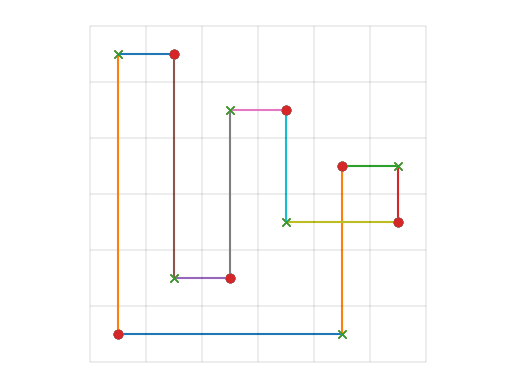

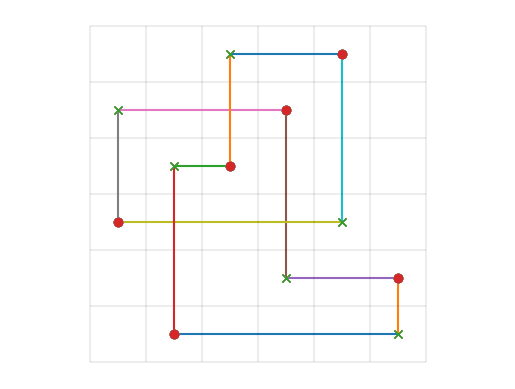

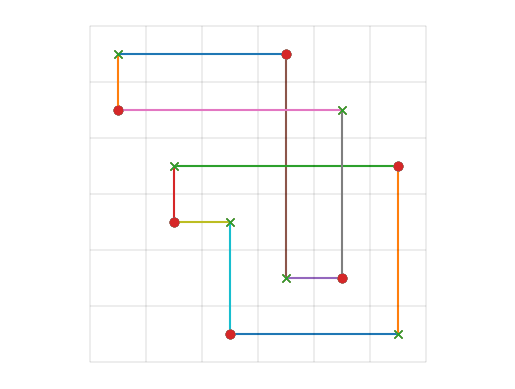

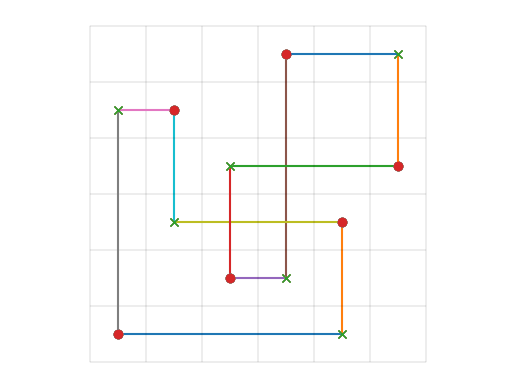

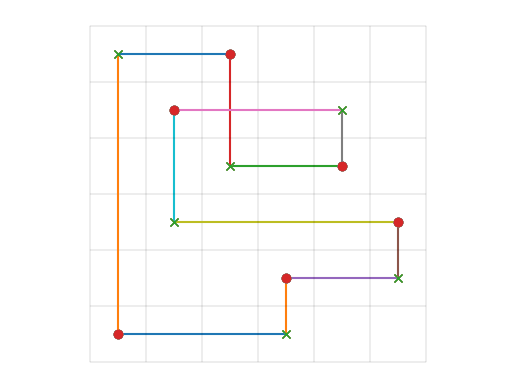

In [236]:
inspect_state(n, statevector, PRINT_ALEXANDER=False)